In this project I use the Auto Regressive-Markov model to create univariate simulated stock data.
Furthermore, I demonstrate how we the simulated stock data can be used to evaluate a trading strategy.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from data_download_script import load_daily_data, intraday_data
import scipy as sp
import hmmlearn.hmm as hmm
import quantstats as qs

from tqdm import tqdm
from statsmodels.api import tsa

Start by creating a function to import data. The file for this project can be found at https://mega.nz/file/lXETlQBB#OvWnm7URTQaiBT1rYUna5Ya-t8EZcm-j3nD_PGhCcA0

In [21]:
def intraday_data(ticker = 'SPY', interval = '1h'):
    df = pd.read_parquet(f'{ticker}.parquet')
    df = df.reset_index()
    df = df.sort_values(by = 'datetime')
    df = df.set_index(['datetime'])
    df = df.drop('index', axis=1)
    
    if interval == 'original':
        return df
    else:
    
        df = df.between_time('09:30', '16:00')

        ohlc_dict = {                                                                                                        
            'open': 'first',                                                                                                    
            'high': 'max',                                                                                                       
            'low': 'min',                                                                                                        
            'close': 'last',                                                                                                    
            'volume': 'sum',
            }

        df = df.resample(interval, closed = 'left', label = 'left').apply(ohlc_dict).dropna()
    
        return df


In [22]:
df = intraday_data('SPY')
ts = df.close.pct_change().dropna()
ts

datetime
2007-04-24 10:00:00   -0.003580
2007-04-24 11:00:00    0.002102
2007-04-24 12:00:00    0.001082
2007-04-24 13:00:00    0.000608
2007-04-24 14:00:00    0.000405
                         ...   
2021-05-04 12:00:00    0.001645
2021-05-04 13:00:00    0.001720
2021-05-04 14:00:00    0.001354
2021-05-04 15:00:00    0.003816
2021-05-04 16:00:00   -0.000914
Name: close, Length: 28237, dtype: float32

In [23]:
model_AR_markov = tsa.MarkovAutoregression(ts.values, 2, 2, switching_ar = True, switching_variance = True)
fitted = model_AR_markov.fit()

Next, we fit a Autoregressive markov model with order $p$. This is essentially an Autoregressive model, but with state-varying parameters which follows an order 1 markov process. That is:

$y_t = \mu_{S_t} + \sum_i^p\phi_{i,S_{t-i}}(y_{t-1-i} - \mu_{S_{t - i}}) + \epsilon_{S_t}$

Here,
* $S_t$ is the state, which follows a markov process of order 1.
* $y_t$ is the price return.
* $\mu_{S_t}$ is the model mean given state $S_t$
* $\phi_{i,S_{t}}$ is the $i^{th}$ order autoregressive coefficient given state $S_t$
* $\epsilon_{S_t} \in \mathcal{N}(0,\sigma^2_{S_t})$ is the error term with variance dependent on state $S_t$.

In this project we only assume an order of $p=2$ AR-markov process.

When we have fitted tha AR-Markov model, we can extract the parameters.

In [24]:
params = fitted.params
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                        y   No. Observations:                28235
Model:             MarkovAutoregression   Log Likelihood              123884.765
Date:                  Sun, 16 Oct 2022   AIC                        -247749.531
Time:                          21:11:11   BIC                        -247667.048
Sample:                               0   HQIC                       -247722.989
                                - 28235                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   1.45e-05     12.755      0.000       0.000       0.000
sigma2      2.703e-06   5.42e-08     49.844      0.000     2.6e-06    2.81e-06
ar.L1          0.0012      0.007      0.187      0.851      -0.012       0.014
ar.L2          0.0170      0.006      2.908      0.004       0.006       0.028
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003   5.04e-05     -6.092      0.000      -0.000      -0.000
sigma2      6.586e-05   1.48e-06     44.390      0.000     6.3e-05    6.88e-05
ar.L1         -0.0419      0.010     -4.095      0.000      -0.062      -0.022
ar.L2         -0.0352      0.013     -2.796      0.005      -0.060      -0.011
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.8845      0.004    203.240      0.000       0.876       0.893
p[1->0]        0.3524      0.013     27.157      0.000       0.327       0.378
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Now when we have fitted a model and estimated the parameters, we can create a function that simulate paths following the AR markov process.

In [31]:
def simulate_ar_markov_process(n, params):

    p00 = params[0];p01 = 1 - p00
    p10 = params[1];p11 = 1 - p10
    
    p = np.array([p11,p01])
    const = np.array([params[2],params[3]])
    var = np.array([params[4],params[5]])
    ar1 = np.array([params[6],params[7]])
    ar2 = np.array([params[8], params[9]])

    state_vector = np.empty(n)
    state_vector[0] = 0
    for i in range(1, n):
        if state_vector[i-1] == 1:
            state_vector[i] = sp.random.binomial(1, p[0], 1)[0].astype(int)
        
        if state_vector[i-1] == 0:
            state_vector[i] = sp.random.binomial(1, p[1], 1)[0].astype(int)
            
    process = np.array([np.zeros(n),state_vector]).transpose()
    process[0,0] = const[0] + sp.random.normal(0, np.sqrt(var[0]))
    process[1,0] = const[1] + sp.random.normal(0, np.sqrt(var[1]))
    
    for i in range(3, n):
        [j,k,l] = process[(i-3):i,1].astype(int).tolist()
        process[i - 1, 0] = const[l] + np.dot(process[(i - 3):(i - 1),0] - np.array([const[j], const[k]]), 
                                         np.array([ar2[j],ar1[k]])) + sp.random.normal(0, np.sqrt(var[l]))
        
    return pd.Series((1 + process[:,0]).cumprod())

Plot 100 simulations

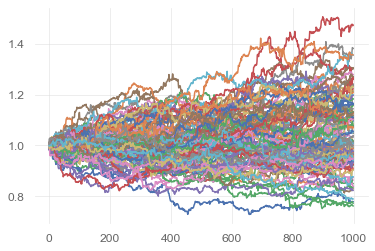

In [32]:
paths = np.empty((100, 1000))
for i in range(100):
    paths[i,:] = simulate_ar_markov_process(1000, params)
    plt.plot(paths[i,:])

plt.show()

Now when we can create simulated stock data we want to use when testing at trading strategy. The simulated data will be helpfull since it will reduce bias and noise when testing our strategy.

We start by creating a trading strategy. In this project we train a Hidden Markov model with Gaussian mixture emissions on the SPY returns data. This model fits two differents hidden states which is used as momentum regimes. So using two state HMM we get:
* state 0: Buy on close.
* state 1: Sell on close or remain neutral.

To learn more: https://en.wikipedia.org/wiki/Hidden_Markov_model, https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.hmm.GMMHMM.html

In [33]:
n = np.floor(ts.shape[0] * 0.7).astype(int)
hmm_model = hmm.GMMHMM(n_components = 2, n_iter = 1000, algorithm = 'baum-welch')

train = ts.iloc[:n].values.reshape(-1, 1)
test = ts.iloc[n:].values.reshape(-1, 1)
hmm_model = hmm_model.fit(train)

Extract the parameters for fitted AR_Markov model on training data.

In [35]:
model_AR_markov = tsa.MarkovAutoregression(ts.iloc[:n].values, 2, 2, switching_ar = True, switching_variance = True)
fitted = model_AR_markov.fit()
params = fitted.params

100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.23it/s]


Upper std sharpe on simulated paths: 3.321
Mean sharpe on simulated paths: 2.878
Lower std sharpe on simulated paths: 2.436
Sharpe on real data: 3.227
Sharpe on SPY: 0.741


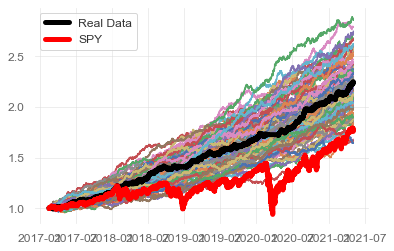

In [37]:
# 100 different simulated paths
m = 100
test = ts.iloc[n:].values.reshape(-1, 1)
oos = np.empty((m + 1, ts.iloc[n:].shape[0]))
for i in tqdm(range(m)):
    # Simulate the path using AR Markov process
    df_test = simulate_ar_markov_process(ts.iloc[n:].shape[0] + 1, params).pct_change().dropna()
    df_test_shaped = df_test.values.reshape(-1, 1)
    
    # Test strategy on simulated data, if 0.9 likelihood of being in state 1 -> Go long on close, else neutral.
    oos[i,:] = np.where(hmm_model.predict_proba(df_test_shaped)[:,0] > 0.9, df_test.shift(-1), 0)

# Test the strategy on real oos data as well
oos[-1,:] = np.where(hmm_model.predict_proba(test)[:,0] > 0.9, ts.iloc[n:].shift(-1), 0)
oos = pd.DataFrame(oos.transpose(), index = ts.iloc[n:].index).dropna()

# Plot all returns
for i in range(m):
    plt.plot((1 + oos[i]).cumprod())

plt.plot((1 + oos[m]).cumprod(), linewidth=5, color = 'black', label = 'Real Data')
plt.plot((1 + ts.iloc[n:]).cumprod(), linewidth=5, color = 'red', label = 'SPY')
plt.legend()

# Calculate sharpe
print(f'Upper std sharpe on simulated paths: {round(np.mean(oos.iloc[:-2,:].apply(qs.stats.sharpe, periods = 252 * 6.5)) + np.std(oos.iloc[:-2,:].apply(qs.stats.sharpe, periods = 252 * 6.5)),3)}')
print(f'Mean sharpe on simulated paths: {round(np.mean(oos.iloc[:-2,:].apply(qs.stats.sharpe, periods = 252 * 6.5)),3)}')
print(f'Lower std sharpe on simulated paths: {round(np.mean(oos.iloc[:-2,:].apply(qs.stats.sharpe, periods = 252 * 6.5)) - np.std(oos.iloc[:-2,:].apply(qs.stats.sharpe, periods = 252 * 6.5)),3)}')
print(f'Sharpe on real data: {round(qs.stats.sharpe(oos[m], periods = 252 * 6.5),3)}')
print(f'Sharpe on SPY: {round(qs.stats.sharpe(ts.iloc[n:], periods = 252 * 6.5),3)}')
plt.show()